In [11]:
import pandas as pd
import numpy as np
import os

In [4]:
train_anno = pd.read_json(r"E:\LiveProject\Deep_Learning\Penguins vs Turtles\train_annotations")

In [5]:
train_anno.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,2,"[225, 298, 198, 185]",36630,[],0
3,3,3,2,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


In [6]:
# lets see how many classes are present in the category id
train_anno["category_id"]. unique()

array([1, 2], dtype=int64)

In [7]:
# if image_id 0 is penguin, class 1 indicates the penguin, class 2 indicates the turtle
# deleting unwanted columns
train_anno = train_anno. drop(["id", "bbox", "area", "segmentation", "iscrowd"], axis = 1)

In [8]:
train_anno["category_id"] = train_anno["category_id"]. replace({1:"Penguin", 2:"Turtle"})

In [9]:
train_anno. head()

,image_id,category_id
0,0,Penguin
1,1,Penguin
2,2,Turtle
3,3,Turtle
4,4,Penguin


In [ ]:
#I want to create a dataframe with 2 columns filepaths and labels where the entries in the filepaths
# column is the full path to the image file and the entries in the labels column is the text label of
# of the class
# first lets change the column names

In [10]:
train_anno.columns = ['filepaths', 'labels']
train_anno. head()

,filepaths,labels
0,0,Penguin
1,1,Penguin
2,2,Turtle
3,3,Turtle
4,4,Penguin


In [12]:
# now in the filepaths column create the full path to the image file
train_image_dir=r"E:\LiveProject\Deep_Learning\Penguins vs Turtles\train\train"

In [16]:
train_imglist = sorted(os. listdir(train_image_dir))

In [18]:
train_paths = []
for i in range (len(train_imglist)):
    train_paths. append(os. path. join(train_image_dir, train_imglist[i]))
print(train_paths[0])

E:\LiveProject\Deep_Learning\Penguins vs Turtles\train\train\image_id_000.jpg


In [19]:
# now in the train_anno filepaths column insert the full filepath
train_anno['filepaths']=train_paths
print (train_anno.head())

                                           filepaths   labels
0  E:\LiveProject\Deep_Learning\Penguins vs Turtl...  Penguin
1  E:\LiveProject\Deep_Learning\Penguins vs Turtl...  Penguin
2  E:\LiveProject\Deep_Learning\Penguins vs Turtl...   Turtle
3  E:\LiveProject\Deep_Learning\Penguins vs Turtl...   Turtle
4  E:\LiveProject\Deep_Learning\Penguins vs Turtl...  Penguin


In [59]:
# Save the data to a CSV file
#train_anno.to_csv('train_anno.csv', index=False)

In [ ]:
## valid annotations

In [20]:
# Do the same for the valid annotations
valid_df=pd.read_json(r"E:\LiveProject\Deep_Learning\Penguins vs Turtles\valid_annotations")
valid_df=valid_df.drop(['id', 'bbox', 'area', 'segmentation', 'iscrowd'], axis =1)

In [21]:
# lets replace the numeric class designation with the test name of the class
valid_df['category_id']=valid_df['category_id'].replace({1:'Penguin',2:'Turtle'})
valid_df.columns=['filepaths', 'labels']

In [22]:
# now in the filepaths column create the full path to the image file
valid_image_dir=r"E:\LiveProject\Deep_Learning\Penguins vs Turtles\valid\valid"
valid_imglist=sorted(os.listdir(valid_image_dir))

In [23]:
valid_paths=[]
for i in range (len(valid_imglist)):
    valid_paths.append(os.path.join(valid_image_dir, valid_imglist[i]))
valid_df['filepaths']=valid_paths
valid_df.head()

,filepaths,labels
0,E:\LiveProject\Deep_Learning\Penguins vs Turtl...,Penguin
1,E:\LiveProject\Deep_Learning\Penguins vs Turtl...,Turtle
2,E:\LiveProject\Deep_Learning\Penguins vs Turtl...,Turtle
3,E:\LiveProject\Deep_Learning\Penguins vs Turtl...,Penguin
4,E:\LiveProject\Deep_Learning\Penguins vs Turtl...,Penguin


In [65]:
# Save the data to a CSV file
#valid_df.to_csv('valid_anno.csv', index=False)

In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.utils import class_weight
from tensorflow. keras.optimizers import Adamax

In [28]:
# Data preprocessing
#datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create train and validation generators

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #rotation_range=45,
                                   #vertical_flip=True,
                                   fill_mode='nearest')

In [42]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [44]:
train_generator = train_datagen. flow_from_dataframe(dataframe = train_anno,
                                                    x_col="filepaths",
                                                    color_mode='rgb',
                                                    y_col="labels",
                                                    target_size=(200, 200),
                                                    batch_size=40,
                                                     seed = 123,
                                                    class_mode="binary")

Found 500 validated image filenames belonging to 2 classes.


In [45]:
test_generator = test_datagen. flow_from_dataframe(dataframe = valid_df,
                                                  x_col = "filepaths",
                                                  y_col = "labels",
                                                   color_mode='rgb',
                                                  target_size = (200,200),
                                                   seed = 123,
                                                   batch_size = 40,
                                                   class_mode = "binary")

Found 72 validated image filenames belonging to 2 classes.


In [46]:
# Build the model with VGG16
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', 
                                                    include_top=False, 
                                                    input_shape=(100, 100, 3), 
                                                    pooling='max')

In [47]:
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [55]:
# compling the model
learning_rate = 0.001
optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
# lets define 2 callbacks , reduce learning rate on plateau and early stopping
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4,  patience=2,
                                            verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4,restore_best_weights=True)
callbacks=[rlronp, estop]

In [58]:
history = model.fit(train_generator, epochs=50, callbacks=callbacks, validation_data=test_generator)

Epoch 1/50
13/13 [==============================] - 25s 1s/step - loss: 3.0260 - accuracy: 0.5320 - val_loss: 2.2421 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 15s 1s/step - loss: 1.5351 - accuracy: 0.4800 - val_loss: 1.3784 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 14s 1s/step - loss: 1.1015 - accuracy: 0.4820 - val_loss: 0.7477 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 15s 1s/step - loss: 0.9555 - accuracy: 0.4800 - val_loss: 0.7005 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 15s 1s/step - loss: 0.7961 - accuracy: 0.5180 - val_loss: 0.7025 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.5320
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
13/13 [==============================] - 15s 1s/step - loss: 0.73

In [60]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 2s 712ms/step - loss: 0.6922 - accuracy: 0.4861
Test Loss: 0.69222491979599
Test Accuracy: 0.4861111044883728


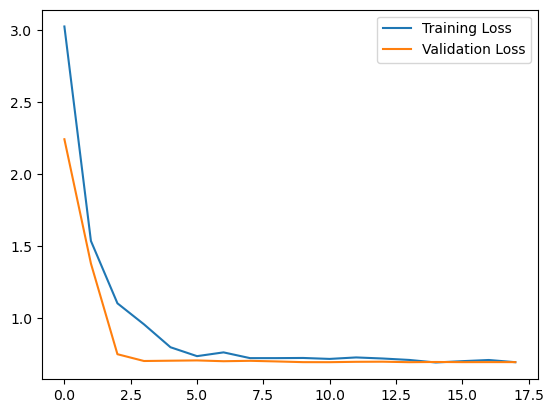

<Figure size 640x480 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

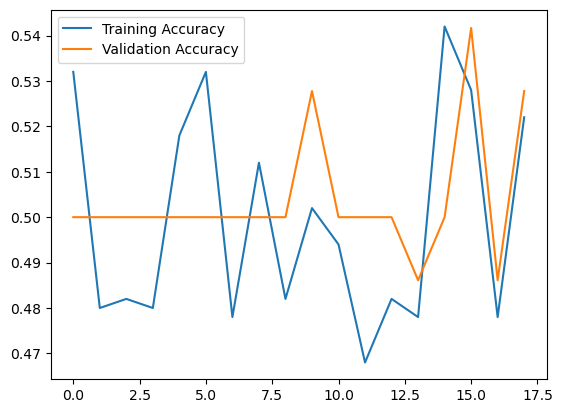

<Figure size 640x480 with 0 Axes>

In [62]:
# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [63]:
# Save the model
model.save("your_model.h10")

INFO:tensorflow:Assets written to: your_model.h10\assets


INFO:tensorflow:Assets written to: your_model.h10\assets


In [64]:
import pickle
pickle. dump(model, open("penguine_turtles.pkl", "wb"))